## Solving the Directional Solidification problem using PINN

###Constants:</br>
$C_0 = 1$</br>
$k_0 = 0.1$</br>
$v_p = 1$</br>
$D_l = 1$</br>


###Conditions:</br>
Domain $\epsilon > 0 $</br>
PDE1: $\frac{∂C_l}{∂\tau}-\frac{∂C_l}{∂\epsilon} = \frac{∂^2C_l}{∂\epsilon^2}$</br>
Interface $ϵ=0$</br>
PDE2: $-\frac{∂C_l}{∂ϵ}=C_l^*(1-k_0)$</br>
Initial $τ=0$</br>
$C_l = C_0$

###Code

In [ ]:
import tensorflow as tf
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float
C0 = tf.constant(1, dtype=DTYPE)
k0 = C0*0.1

In [ ]:
def f1(c_t, c_z, c_zz): # calculates PDE1 value given c's derivatives
  return c_t - c_z - c_zz

def f2(c_z, c_star): # calculates PDE2 value
  return c_star*(1-k0) + c_z

In [ ]:
def c2_anal(t,z): # calculates c2 value from its analytical solution
  return 1 + (tf.math.erfc((z-t)/(2*(t**0.5)))*tf.math.exp(-z)*(1-k0)/(2*k0)) - (0.5*tf.math.erfc((z+t)/(2*(t**0.5)))) + (tf.math.erfc((z+(2*k0-1)*t)/(2*(t**0.5)))*tf.math.exp(-(z+k0*t)*(1-k0))*(1-1/(2*k0)))

In [ ]:
Nm = 200 # no of measurement points

tmin, tmax = tf.constant(0.), tf.constant(25.) # lower and upper limit on time
zmin, zmax = tf.constant(0.), tf.constant(10.) # lower and upper limit on z

tf.random.set_seed(0) # random seed for reproducible results

tm = tf.random.uniform((Nm,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
zm = tf.random.uniform((Nm,1), zmin, zmax, dtype=DTYPE) # uniformly sample bwn zmin and zmax
meas = tf.concat([tm, zm], axis=1) # Measurement Data Points
cm = c2_anal(tm,zm) # Analytical value of c at these points

In [ ]:
def c_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for c
  return model

In [ ]:
def get_f(cmodel, cps): # calculate f values given model and collocation points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, z = cps[:, 0:1], cps[:, 1:2] # extract t and z data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(z)
    c = cmodel(tf.concat([t, z], axis=1)) # c as a function of t and z
    s = tf.zeros(shape=tf.shape(t), dtype=DTYPE)
    tape.watch(s)
    cb = cmodel(tf.concat([t, s], axis=1))
    # defined within context to compute 2nd derivatives
    c_z = tape.gradient(c, z)
  cb_z = tape.gradient(cb, s)
  c_t = tape.gradient(c, t)
  c_zz = tape.gradient(c_z, z)
  del tape
  return f1(c_t, c_z, c_zz), f2(cb_z, cb)

In [ ]:
def loss_fxn(cmodel, mea, cm, coll): # compute Loss given model and data

  zc = coll[:,1:2]
  ti = tf.zeros(shape=tf.shape(zc), dtype=DTYPE)
  init = tf.concat([ti, zc], axis=1)
  pc2i = cmodel(init) # predicted initial conc of liquid
  Li = tf.reduce_mean(tf.square(pc2i-C0)) # MSE for initial data

  pcm = cmodel(mea) # Concentration prediction on measurement data
  Lm = tf.reduce_mean(tf.square(cm - pcm)) # MSE for measurement data

  f_1, f_2 = get_f(cmodel, coll) # calculate f values given model and collocation data
  Lc = tf.reduce_mean(tf.square(f_1)) + tf.reduce_mean(tf.square(f_2)) # MSE in PDE values for collocation data

  loss = Li + Lc + Lm

  return loss

In [ ]:
def L_and_grad_Lw(cmodel, mea, cm, coll): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    loss = loss_fxn(cmodel, mea, cm, coll) # loss as a function of model (& hence weights)
  gc = tape.gradient(loss, cmodel.trainable_variables)
  del tape
  return loss, gc

In [ ]:
Nc = 10000 # No of collocation points
cmodel = c_model() # initialise the Conc NN model
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3500],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.Adam(learning_rate=lr) # Adam Optimiser

In [ ]:
def train_step(coll):
  # compute loss and its gradient wrt model parameters
  loss, gc = L_and_grad_Lw(cmodel, meas, cm, coll)
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gc, cmodel.trainable_variables))
  return loss

In [ ]:
from time import time
N = 5000 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  zc = tf.random.uniform((Nc,1), zmin, zmax, dtype=DTYPE) # uniformly sample bwn zmin and zmax
  coll = tf.concat([tc, zc], axis=1) # Collocation Data Points
  loss = train_step(coll)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

Final Loss = 0.00020573879
Computation Time = 16.117248555024464 minutes


In [ ]:
from time import time
N = 5000 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  zc = tf.random.uniform((Nc,1), zmin, zmax, dtype=DTYPE) # uniformly sample bwn zmin and zmax
  coll = tf.concat([tc, zc], axis=1) # Collocation Data Points
  loss = train_step(coll)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

Final Loss = 0.00015280854
Computation Time = 13.952884169419606 minutes


Text(0, 0.5, 'Loss')

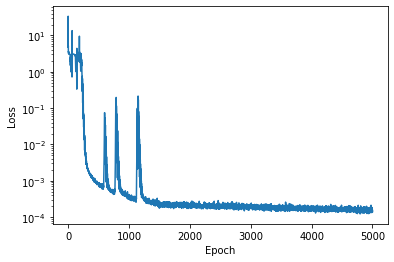

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'C (Concentration in Liquid)')

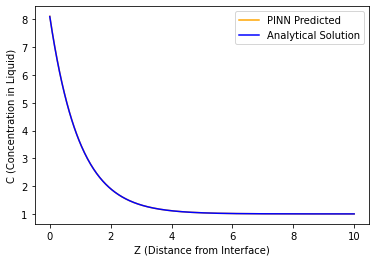

In [ ]:
N = 500
zspace = np.expand_dims(np.linspace(zmin, zmax, N+1),axis=1)
tspace = np.ones_like(zspace)*16
Z = tf.cast(zspace,DTYPE)
T = tf.cast(tspace,DTYPE)
cpred = cmodel(tf.concat([T, Z], axis=1)).numpy()
ctrue = c2_anal(T,Z).numpy()
plt.plot(Z,cpred,color='orange')
plt.plot(Z,ctrue,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('Z (Distance from Interface)')
plt.ylabel('C (Concentration in Liquid)')

In [ ]:
import pickle
filename = 'ds_cmodel.sav'
pickle.dump(cmodel, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-02-16 18:46:55       182632
metadata.json                                  2023-02-16 18:46:55           64
config.json                                    2023-02-16 18:46:55         2845


In [ ]:
import pickle
filename = '/content/ds_cmodel.sav'
cmodel = pickle.load(open(filename,'rb'))

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-02-16 18:46:54       182632
metadata.json                                  2023-02-16 18:46:54           64
config.json                                    2023-02-16 18:46:54         2845
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
...vars


In [ ]:
import tensorflow as tf
DTYPE = 'float32'
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'C (Concentration in Liquid)')

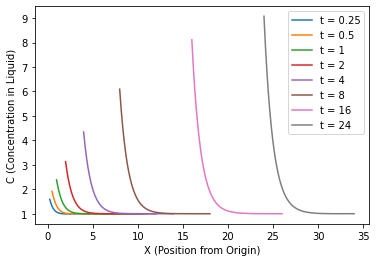

In [ ]:
t_values = [0.25,0.5,1,2,4,8,16,24]
N = 500
zmin, zmax = tf.constant(0.), tf.constant(10.)
zspace = np.expand_dims(np.linspace(zmin, zmax, N+1),axis=1)
Z = tf.cast(zspace,DTYPE)
for t in t_values:
    tspace = np.ones_like(zspace)*t
    T = tf.cast(tspace,DTYPE)
    cpred = cmodel(tf.concat([T, Z], axis=1)).numpy()
    X = Z + T
    plt.plot(X,cpred)
plt.legend(['t = 0.25','t = 0.5','t = 1','t = 2','t = 4','t = 8','t = 16','t = 24'])
plt.xlabel('X (Position from Origin)')
plt.ylabel('C (Concentration in Liquid)')
plt.title('Predicted Profiles using PINN')

Text(0.5, 1.0, 'Graphs via Analytical Solution')

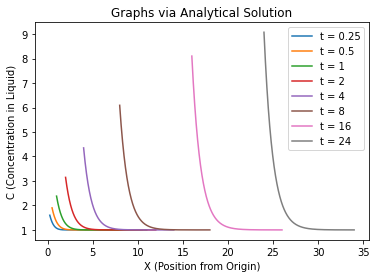

In [ ]:
for t in t_values:
    tspace = np.ones_like(zspace)*t
    T = tf.cast(tspace,DTYPE)
    ctrue = c2_anal(T,Z).numpy()
    X = Z + T
    plt.plot(X,ctrue)
plt.legend(['t = 0.25','t = 0.5','t = 1','t = 2','t = 4','t = 8','t = 16','t = 24'])
plt.xlabel('X (Position from Origin)')
plt.ylabel('C (Concentration in Liquid)')
plt.title('Graphs via Analytical Solution')